# Data Preprocessing Project 
### Team: Survivors

In [1]:
# Warming Up
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

fPath = './data/vgsales.csv'
df = pd.read_csv(fPath)

# trying to create 1.5% worth of duplicates
rws = df.shape[0]
col = df.shape[1]

print('Number of instances = %d' % (rws))
print('Number of attributes = %d' % (col))
print(df.head())
# Tables that Michael Berbach will use
dfMB = df

Number of instances = 16598
Number of attributes = 11
   Rank                      Name Platform    Year         Genre Publisher  \
0     1                Wii Sports      Wii  2006.0        Sports  Nintendo   
1     2         Super Mario Bros.      NES  1985.0      Platform  Nintendo   
2     3            Mario Kart Wii      Wii  2008.0        Racing  Nintendo   
3     4         Wii Sports Resort      Wii  2009.0        Sports  Nintendo   
4     5  Pokemon Red/Pokemon Blue       GB  1996.0  Role-Playing  Nintendo   

   NA_Sales  EU_Sales  JP_Sales  Other_Sales  Global_Sales  
0     41.49     29.02      3.77         8.46         82.74  
1     29.08      3.58      6.81         0.77         40.24  
2     15.85     12.88      3.79         3.31         35.82  
3     15.75     11.01      3.28         2.96         33.00  
4     11.27      8.89     10.22         1.00         31.37  


# Missing Values

Author: Micheal Berbach | The purpose of this is to find any missing values 

In [2]:
data = df.replace('?',np.NaN)

print('Number of instances = %d' % (rws))
print('Number of attributes = %d' % (col))

print('Number of missing values:')
for col in df.columns:
    print('\t%s: %d' % (col,df[col].isna().sum()))

Number of instances = 16598
Number of attributes = 11
Number of missing values:
	Rank: 0
	Name: 0
	Platform: 0
	Year: 271
	Genre: 0
	Publisher: 58
	NA_Sales: 0
	EU_Sales: 0
	JP_Sales: 0
	Other_Sales: 0
	Global_Sales: 0


In [3]:
print('Number of rows in original data = %d' % (rws))
df = df.dropna()
print('Number of rows after discarding missing values = %d' % (df.shape[0]))
print('Difference in number of rows = %d' % (rws-df.shape[0]))
# update rws
rws = df.shape[0]

Number of rows in original data = 16598
Number of rows after discarding missing values = 16291
Difference in number of rows = 307


# Outliers
Author: Rahul Gupta | One way of preprocessing the data set is to prepare it for predicting a video game's sales based on its genre. It could be useful for publishers to know what genre of game to develop based on a prediction with this data. To do so, we will need to prepare the data set for normalization and remove outliers.

### One Hot Encoding
Start by using one-hot encoding to convert the genre categorical attribute into numerical values. One-hot encoding is crucial if we are including genre and normalizing the data set since categorical attributes without one-hot encoding are not compatible with normalization.

In [4]:
normalized = df
one_hot = pd.get_dummies(normalized['Genre'])

one_hot[20:23]

,Action,Adventure,Fighting,Misc,Platform,Puzzle,Racing,Role-Playing,Shooter,Simulation,Sports,Strategy
20,False,False,False,False,False,False,False,True,False,False,False,False
21,False,False,False,False,True,False,False,False,False,False,False,False
22,False,False,False,False,True,False,False,False,False,False,False,False


### Dropping Columns
We also need to drop columns that do not fit the specific needs of the neural network. In this case, anything that is not genre or sales data. However, we will also drop genre as well and later replace it with the one-hot encoded columns made in the previous step.

In [5]:
print('Number of columns before discarding columns = %d' % (normalized.shape[1]))

normalized = normalized.drop(['Rank', 'Name', 'Platform', 'Genre', 'Year', 'Publisher'], axis=1)

print('Number of columns after discarding columns = %d' % (normalized.shape[1]))

Number of columns before discarding columns = 11
Number of columns after discarding columns = 5


### Concatenating Rows and Columns
After dropping the unnecessary columns, we now want to add the one-hot encoded genres to the main dataframe. To add the one-hot encoded rows and columns to the dataframe, we will use the pandas function concat, which will combine them both into one dataframe.

In [6]:
normalized = pd.concat([one_hot, normalized], axis=1)

normalized[20:23]

,Action,Adventure,Fighting,Misc,Platform,Puzzle,Racing,Role-Playing,Shooter,Simulation,Sports,Strategy,NA_Sales,EU_Sales,JP_Sales,Other_Sales,Global_Sales
20,False,False,False,False,False,False,False,True,False,False,False,False,6.42,4.52,6.04,1.37,18.36
21,False,False,False,False,True,False,False,False,False,False,False,False,10.83,2.71,4.18,0.42,18.14
22,False,False,False,False,True,False,False,False,False,False,False,False,9.54,3.44,3.84,0.46,17.28


### Normalization
Now, we will normalize the data to find and remove any outliers. Doing so will make it easier for the neural network to find and identify patterns with genre and sales data. All data will be converted into z scores with the following formula: z score = (x - mean)/standard deviation.

In [7]:
normalized = (normalized-normalized.mean())/normalized.std()

normalized[20:23]

,Action,Adventure,Fighting,Misc,Platform,Puzzle,Racing,Role-Playing,Shooter,Simulation,Sports,Strategy,NA_Sales,EU_Sales,JP_Sales,Other_Sales,Global_Sales
20,-0.499294,-0.291259,-0.232571,-0.339754,-0.238235,-0.190407,-0.285138,3.175168,-0.29225,-0.234325,-0.40585,-0.207095,7.483114,8.584810,19.113686,6.952620,11.368968
21,-0.499294,-0.291259,-0.232571,-0.339754,4.197285,-0.190407,-0.285138,-0.314925,-0.29225,-0.234325,-0.40585,-0.207095,12.845259,5.030933,13.149844,1.954799,11.228603
22,-0.499294,-0.291259,-0.232571,-0.339754,4.197285,-0.190407,-0.285138,-0.314925,-0.29225,-0.234325,-0.40585,-0.207095,11.276740,6.464264,12.059680,2.165234,10.679905


### Removing Outliers
After getting z scores, it is now possible to find outliers and remove them. Since all columns have been converted into z scores, we need to see if values are greater than -3 or less than or equal to 3. Rows that fall into that range are not outliers and are included in removed_outliers. However, rows that fall outside of that range are outliers and are excluded from the dataframe removed_outliers.


In [8]:
print('Number of rows before discarding outliers = %d' % (normalized.shape[0]))

removed_outliers = normalized.loc[((normalized > -3).sum(axis=1)==17) & ((normalized <= 3).sum(axis=1)==17)]
print('Number of rows after discarding outliers values = %d' % (removed_outliers.shape[0]))

removed_outliers[20:23]

Number of rows before discarding outliers = 16291
Number of rows after discarding outliers values = 7060


,Action,Adventure,Fighting,Misc,Platform,Puzzle,Racing,Role-Playing,Shooter,Simulation,Sports,Strategy,NA_Sales,EU_Sales,JP_Sales,Other_Sales,Global_Sales
325,2.002705,-0.291259,-0.232571,-0.339754,-0.238235,-0.190407,-0.285138,-0.314925,-0.29225,-0.234325,-0.405850,-0.207095,1.889947,2.144635,1.254224,1.060453,2.060230
327,-0.499294,-0.291259,-0.232571,2.943125,-0.238235,-0.190407,-0.285138,-0.314925,-0.29225,-0.234325,-0.405850,-0.207095,2.084492,2.596232,-0.252768,1.428713,2.053849
339,-0.499294,-0.291259,-0.232571,-0.339754,-0.238235,-0.190407,-0.285138,-0.314925,-0.29225,-0.234325,2.463813,-0.207095,2.266878,2.026827,-0.220704,1.586539,1.996428


# Duplicate Data

Author: Micheal Berbach | The purpose of this is to find any duplicate datas 

In [9]:

# It was found that duplicates exist when the rank attribute is removed
dfMB = dfMB.drop(['Rank'], axis=1)
dups = dfMB.duplicated()
print('Number of duplicate rows = %d' % (dups.sum()))
dfMB.loc[dfMB.duplicated(keep=False)]

Number of duplicate rows = 1


,Name,Platform,Year,Genre,Publisher,NA_Sales,EU_Sales,JP_Sales,Other_Sales,Global_Sales
14997,Wii de Asobu: Metroid Prime,Wii,NaN,Shooter,Nintendo,0.0,0.0,0.02,0.0,0.02
14999,Wii de Asobu: Metroid Prime,Wii,NaN,Shooter,Nintendo,0.0,0.0,0.02,0.0,0.02


In [10]:
print('Number of rows before discarding duplicates = %d' % (rws))
dfMB = dfMB.drop_duplicates()
print('Number of rows after discarding duplicates = %d' % (dfMB.shape[0]))

Number of rows before discarding duplicates = 16291
Number of rows after discarding duplicates = 16597


# Shuffling Dataframes

Author: Micheal Berbach

In [11]:
dfMB = dfMB.reindex(np.random.permutation(dfMB.index))
dfMB.reset_index(inplace=True, drop=True)
dfMB
# Shuffling is aparent as it was
# originally ranked in order of global sales

,Name,Platform,Year,Genre,Publisher,NA_Sales,EU_Sales,JP_Sales,Other_Sales,Global_Sales
0,Cabela's Dangerous Hunts 2,XB,2005.0,Sports,Activision,0.08,0.02,0.00,0.00,0.11
1,Final Fantasy II,SNES,1991.0,Role-Playing,Square,0.24,0.09,1.33,0.12,1.77
2,Fireblade,XB,2002.0,Action,Midway Games,0.06,0.02,0.00,0.00,0.08
3,Pirates of the Caribbean: Dead Man's Chest,GBA,2006.0,Adventure,Disney Interactive Studios,0.33,0.12,0.00,0.01,0.47
4,Child of Eden,X360,2011.0,Shooter,Ubisoft,0.28,0.12,0.00,0.04,0.44
...,...,...,...,...,...,...,...,...,...,...
16592,Diabolik Lovers: Dark Fate,PSV,2015.0,Action,Idea Factory,0.00,0.00,0.03,0.00,0.03
16593,Mega Man Star Force 3: Black Ace / Red Joker,DS,2008.0,Action,Capcom,0.22,0.00,0.22,0.02,0.47
16594,NHL 11,PS3,2010.0,Sports,Electronic Arts,0.40,0.13,0.00,0.07,0.60
16595,Pocket Dogs,GBA,2004.0,Misc,Agatsuma Entertainment,0.06,0.02,0.00,0.00,0.08


# Sorting Dataframes

Author: Micheal Berbach

In [12]:
# sorting first by year, then by global sales
dfMB = dfMB.sort_values(by=['Year','Global_Sales'],ascending=[True, False])
# Also getting rid of any rows that dont have a year
# So we can see the full range
dfMB = dfMB.dropna(subset=['Year'])
dfMB

,Name,Platform,Year,Genre,Publisher,NA_Sales,EU_Sales,JP_Sales,Other_Sales,Global_Sales
15755,Asteroids,2600,1980.0,Shooter,Atari,4.00,0.26,0.00,0.05,4.31
14711,Missile Command,2600,1980.0,Shooter,Atari,2.56,0.17,0.00,0.03,2.76
12914,Kaboom!,2600,1980.0,Misc,Activision,1.07,0.07,0.00,0.01,1.15
8844,Defender,2600,1980.0,Misc,Atari,0.99,0.05,0.00,0.01,1.05
14571,Boxing,2600,1980.0,Fighting,Activision,0.72,0.04,0.00,0.01,0.77
...,...,...,...,...,...,...,...,...,...,...
15803,Coven and Labyrinth of Refrain,PSV,2016.0,Action,Nippon Ichi Software,0.00,0.00,0.01,0.00,0.01
4601,Phantasy Star Online 2 Episode 4: Deluxe Package,PS4,2017.0,Role-Playing,Sega,0.00,0.00,0.03,0.00,0.03
1352,Phantasy Star Online 2 Episode 4: Deluxe Package,PSV,2017.0,Role-Playing,Sega,0.00,0.00,0.01,0.00,0.01
14475,Brothers Conflict: Precious Baby,PSV,2017.0,Action,Idea Factory,0.00,0.00,0.01,0.00,0.01


We can see it spans about 40 years with the data we have left

In [13]:
print("The first game with the most sales is: {}".format(dfMB['Name'].iloc[0]))
print("The first car is: {}".format(dfMB['Name'].loc[0]))
# check readout from shuffling frames if confused by what above line produces

#loc gets rows (or columns) with particular labels from the index.
#iloc gets rows (or columns) at particular positions in the index (so it only takes integers).

The first game with the most sales is: Asteroids
The first car is: Cabela's Dangerous Hunts 2


# Saving a Dataframe

Author: Micheal Berbach

In [14]:
import os

# Relative path within the repository
writeFlnam = os.path.join("data", "vgsalesMB.csv")

# Ensure the 'data' directory exists
os.makedirs(os.path.dirname(writeFlnam), exist_ok=True)

# Save the DataFrame
dfMB.to_csv(writeFlnam, index=False)
print("DataFrame saved to: {}".format(writeFlnam))

DataFrame saved to: data\vgsalesMB.csv


# Shuffle the dataframe

Author: Warisara Lee | The purpose of this is to shuffle the dataframe

In [15]:
df = df.reindex(np.random.permutation(df.index))
df

,Rank,Name,Platform,Year,Genre,Publisher,NA_Sales,EU_Sales,JP_Sales,Other_Sales,Global_Sales
13586,13588,Outlaw Tennis,XB,2005.0,Sports,Global Star,0.03,0.01,0.00,0.00,0.04
14549,14552,Phantasy Star Online 2: Episode 3 Deluxe Package,PSV,2015.0,Action,Sega,0.00,0.00,0.03,0.00,0.03
10787,10789,Pony Friends 2,Wii,2009.0,Simulation,Eidos Interactive,0.04,0.05,0.00,0.01,0.10
5123,5125,Rec Room Games,Wii,2009.0,Sports,Destineer,0.35,0.00,0.00,0.02,0.37
12124,12126,Cartoon Network: Punch Time Explosion XL,PS3,2011.0,Fighting,Crave Entertainment,0.06,0.00,0.00,0.00,0.07
...,...,...,...,...,...,...,...,...,...,...,...
11828,11830,Wrath Unleashed,PS2,2004.0,Strategy,LucasArts,0.04,0.03,0.00,0.01,0.07
11130,11132,El Tigre: The Adventures of Manny Rivera,DS,2007.0,Platform,THQ,0.08,0.00,0.00,0.01,0.09
13395,13397,Cabela's Trophy Bucks,X360,2007.0,Sports,Activision Value,0.04,0.00,0.00,0.00,0.05
5484,5486,Rugby World Cup 2011,PS3,2011.0,Sports,505 Games,0.00,0.25,0.00,0.08,0.33


In [16]:
df.reset_index(inplace=True, drop=True)
df

,Rank,Name,Platform,Year,Genre,Publisher,NA_Sales,EU_Sales,JP_Sales,Other_Sales,Global_Sales
0,13588,Outlaw Tennis,XB,2005.0,Sports,Global Star,0.03,0.01,0.00,0.00,0.04
1,14552,Phantasy Star Online 2: Episode 3 Deluxe Package,PSV,2015.0,Action,Sega,0.00,0.00,0.03,0.00,0.03
2,10789,Pony Friends 2,Wii,2009.0,Simulation,Eidos Interactive,0.04,0.05,0.00,0.01,0.10
3,5125,Rec Room Games,Wii,2009.0,Sports,Destineer,0.35,0.00,0.00,0.02,0.37
4,12126,Cartoon Network: Punch Time Explosion XL,PS3,2011.0,Fighting,Crave Entertainment,0.06,0.00,0.00,0.00,0.07
...,...,...,...,...,...,...,...,...,...,...,...
16286,11830,Wrath Unleashed,PS2,2004.0,Strategy,LucasArts,0.04,0.03,0.00,0.01,0.07
16287,11132,El Tigre: The Adventures of Manny Rivera,DS,2007.0,Platform,THQ,0.08,0.00,0.00,0.01,0.09
16288,13397,Cabela's Trophy Bucks,X360,2007.0,Sports,Activision Value,0.04,0.00,0.00,0.00,0.05
16289,5486,Rugby World Cup 2011,PS3,2011.0,Sports,505 Games,0.00,0.25,0.00,0.08,0.33


# Sort the Dataframe

Author: Warisara Lee

In [17]:
print("Before sorting")
print(df['Global_Sales'])
df = df.sort_values(by='Global_Sales',ascending=True)

print("\nAfter sorting")
print(df['Global_Sales']) 

Before sorting
0        0.04
1        0.03
2        0.10
3        0.37
4        0.07
         ... 
16286    0.07
16287    0.09
16288    0.05
16289    0.33
16290    0.06
Name: Global_Sales, Length: 16291, dtype: float64

After sorting
5201      0.01
13339     0.01
4434      0.01
13296     0.01
987       0.01
         ...  
13847    31.37
12607    33.00
10238    35.82
3136     40.24
14610    82.74
Name: Global_Sales, Length: 16291, dtype: float64


In [18]:
print("df['Global_Sales'].iloc[0] is: {}".format(df['Global_Sales'].iloc[0]))

print("df['Global_Sales'].loc[0] is: {}".format(df['Global_Sales'].loc[0])) 

df['Global_Sales'].iloc[0] is: 0.01
df['Global_Sales'].loc[0] is: 0.04


In [19]:
#Sorting in Ascending Order
#Sorting by column 'NA_Sales'
df = df.sort_values(by=['NA_Sales'],ascending=True)
df

,Rank,Name,Platform,Year,Genre,Publisher,NA_Sales,EU_Sales,JP_Sales,Other_Sales,Global_Sales
5201,16374,S.Y.K: Shinsetsu Saiyuuki Portable,PSP,2010.0,Adventure,Idea Factory,0.00,0.00,0.01,0.00,0.01
14699,11464,Black/Matrix,SAT,1998.0,Strategy,NEC Interchannel,0.00,0.00,0.08,0.00,0.08
948,11396,PoPoLoCrois (JP sales),PSP,2005.0,Role-Playing,Ignition Entertainment,0.00,0.00,0.08,0.00,0.08
12565,11580,My First Songs,Wii,2010.0,Misc,Mindscape,0.00,0.07,0.00,0.01,0.08
16158,11500,AKB1/149: Love Election,PS3,2013.0,Adventure,Namco Bandai Games,0.00,0.00,0.08,0.00,0.08
...,...,...,...,...,...,...,...,...,...,...,...
10238,3,Mario Kart Wii,Wii,2008.0,Racing,Nintendo,15.85,12.88,3.79,3.31,35.82
4991,6,Tetris,GB,1989.0,Puzzle,Nintendo,23.20,2.26,4.22,0.58,30.26
8081,10,Duck Hunt,NES,1984.0,Shooter,Nintendo,26.93,0.63,0.28,0.47,28.31
3136,2,Super Mario Bros.,NES,1985.0,Platform,Nintendo,29.08,3.58,6.81,0.77,40.24


In [20]:
#Sorting in Descending Order
#Sorting by column "EU_Sales"
df = df.sort_values(by=['EU_Sales'], ascending=False)
df

,Rank,Name,Platform,Year,Genre,Publisher,NA_Sales,EU_Sales,JP_Sales,Other_Sales,Global_Sales
14610,1,Wii Sports,Wii,2006.0,Sports,Nintendo,41.49,29.02,3.77,8.46,82.74
10238,3,Mario Kart Wii,Wii,2008.0,Racing,Nintendo,15.85,12.88,3.79,3.31,35.82
12607,4,Wii Sports Resort,Wii,2009.0,Sports,Nintendo,15.75,11.01,3.28,2.96,33.00
1050,11,Nintendogs,DS,2005.0,Simulation,Nintendo,9.07,11.00,1.93,2.75,24.76
15285,17,Grand Theft Auto V,PS3,2013.0,Action,Take-Two Interactive,7.01,9.27,0.97,4.14,21.40
...,...,...,...,...,...,...,...,...,...,...,...
6471,15078,Shaman King: Chou Senjiryokketsu 3,GBA,2002.0,Role-Playing,King Records,0.00,0.00,0.02,0.00,0.02
14754,15196,Motto! SoniComi,PS3,2014.0,Simulation,Kadokawa Games,0.00,0.00,0.02,0.00,0.02
8174,5934,Mega Man ZX,DS,2006.0,Platform,Capcom,0.18,0.00,0.10,0.02,0.30
14809,15739,Memories Off: Yubikiri no Kioku,X360,2010.0,Adventure,5pb,0.00,0.00,0.02,0.00,0.02


# Sampling

Author: Maddie Ananda Subramanian | Sampling the data that we have found

In [21]:
data.head()

,Rank,Name,Platform,Year,Genre,Publisher,NA_Sales,EU_Sales,JP_Sales,Other_Sales,Global_Sales
0,1,Wii Sports,Wii,2006.0,Sports,Nintendo,41.49,29.02,3.77,8.46,82.74
1,2,Super Mario Bros.,NES,1985.0,Platform,Nintendo,29.08,3.58,6.81,0.77,40.24
2,3,Mario Kart Wii,Wii,2008.0,Racing,Nintendo,15.85,12.88,3.79,3.31,35.82
3,4,Wii Sports Resort,Wii,2009.0,Sports,Nintendo,15.75,11.01,3.28,2.96,33.00
4,5,Pokemon Red/Pokemon Blue,GB,1996.0,Role-Playing,Nintendo,11.27,8.89,10.22,1.00,31.37


In [22]:
sample = data.sample(n=10)
sample

,Rank,Name,Platform,Year,Genre,Publisher,NA_Sales,EU_Sales,JP_Sales,Other_Sales,Global_Sales
13034,13036,Doraemon: Nobita no Kyouryuu 2006 DS,DS,2006.0,Role-Playing,Sega,0.00,0.00,0.05,0.00,0.05
3228,3230,Okami,PS2,2006.0,Action,Capcom,0.11,0.03,0.15,0.34,0.63
15554,15557,Tsuki ni Yori Sou Otome no Sahou: Hidamari no ...,PSV,2015.0,Adventure,dramatic create,0.00,0.00,0.02,0.00,0.02
7344,7346,Baja: Edge of Control,PS3,2008.0,Racing,THQ,0.10,0.08,0.00,0.04,0.21
8948,8950,Arena Football,XB,2006.0,Sports,Electronic Arts,0.11,0.03,0.00,0.01,0.15
3298,3300,Cooking Mama 4: Kitchen Magic!,3DS,2011.0,Simulation,505 Games,0.50,0.07,0.00,0.04,0.61
2542,2544,Guitar Hero Live,PS4,2015.0,Misc,Activision,0.32,0.35,0.00,0.13,0.81
16115,16118,Brain Exercise With Dr. Kawashima,PC,2009.0,Puzzle,Namco Bandai Games,0.00,0.01,0.00,0.00,0.01
15200,15203,Indigo Prophecy,PC,2005.0,Adventure,Atari,0.00,0.02,0.00,0.00,0.02
15086,15089,Rugby League Live 3,PS4,2015.0,Action,Tru Blu Entertainment,0.00,0.02,0.00,0.00,0.02


In [23]:
sample = data.sample(frac=0.01, random_state=999)
sample

,Rank,Name,Platform,Year,Genre,Publisher,NA_Sales,EU_Sales,JP_Sales,Other_Sales,Global_Sales
10725,10727,The Land Before Time: Great Valley Racing Adve...,PS,2001.0,Racing,TDK Mediactive,0.05,0.04,0.00,0.01,0.10
9053,9055,Mojo!,PS2,2003.0,Puzzle,Mindscape,0.07,0.05,0.00,0.02,0.14
10102,10104,Vacation Sports,Wii,2009.0,Sports,Ubisoft,0.10,0.01,0.00,0.01,0.11
11876,11878,Disney's Donald Duck Advance,GBA,2001.0,Platform,Ubisoft,0.05,0.02,0.00,0.00,0.07
14561,14564,Gekiatsu!! Pachi Game Tamashi Vol. 1: CR Evang...,PSP,2011.0,Misc,Unknown,0.00,0.00,0.03,0.00,0.03
...,...,...,...,...,...,...,...,...,...,...,...
6592,6594,Silent Hunter 5: Battle of the Atlantic,PC,2010.0,Simulation,Ubisoft,0.00,0.21,0.00,0.05,0.26
4539,4541,EverQuest Online Adventures,PS2,2003.0,Role-Playing,Sony Online Entertainment,0.21,0.16,0.00,0.05,0.43
9920,9922,SD Gundam G Generation-F.I.F,PS,2001.0,Strategy,Namco Bandai Games,0.00,0.00,0.11,0.01,0.12
14440,14443,Eyeshield 21: DevilBats DevilDays,GBA,2006.0,Role-Playing,Nintendo,0.00,0.00,0.03,0.00,0.03


In [24]:
sample = data.sample(frac=0.01, replace=True, random_state=999)
sample

,Rank,Name,Platform,Year,Genre,Publisher,NA_Sales,EU_Sales,JP_Sales,Other_Sales,Global_Sales
12636,12638,Adventures of Lolo,NES,1989.0,Puzzle,HAL Laboratory,0.06,0.00,0.00,0.00,0.06
13157,13159,Nike+ Kinect Training,X360,2012.0,Sports,Microsoft Game Studios,0.02,0.02,0.00,0.00,0.05
5832,5834,Karaoke Revolution Glee: Volume 3,Wii,2011.0,Misc,Konami Digital Entertainment,0.24,0.04,0.00,0.02,0.30
8417,8419,WRC 2: FIA World Rally Championship,PS3,2011.0,Racing,Ubisoft,0.00,0.13,0.00,0.04,0.17
10715,10717,Lord of Apocalypse,PSP,2011.0,Role-Playing,Square Enix,0.00,0.00,0.10,0.00,0.10
...,...,...,...,...,...,...,...,...,...,...,...
5585,5587,Resident Evil: Revelations 2,PS3,2015.0,Action,Capcom,0.06,0.08,0.16,0.03,0.32
10519,10521,God Eater 2: Rage Burst,PS4,2015.0,Role-Playing,Namco Bandai Games,0.00,0.01,0.09,0.00,0.10
6322,6324,Fushigi no Dungeon: Fuurai no Shiren GB: Tsuki...,GB,1996.0,Role-Playing,ChunSoft,0.00,0.00,0.27,0.00,0.27
1982,1984,Forza Motorsport,XB,2005.0,Racing,Microsoft Game Studios,0.52,0.51,0.00,0.02,1.05


# Data before and after dropping any columns

Author: Maddie Ananda Subramanian | The purpose of this is to show how the data is before and dropping certain columns

In [25]:
print("Data before dropping any columns:")
print(df.head())

Data before dropping any columns:
       Rank                Name Platform    Year       Genre  \
14610     1          Wii Sports      Wii  2006.0      Sports   
10238     3      Mario Kart Wii      Wii  2008.0      Racing   
12607     4   Wii Sports Resort      Wii  2009.0      Sports   
1050     11          Nintendogs       DS  2005.0  Simulation   
15285    17  Grand Theft Auto V      PS3  2013.0      Action   

                  Publisher  NA_Sales  EU_Sales  JP_Sales  Other_Sales  \
14610              Nintendo     41.49     29.02      3.77         8.46   
10238              Nintendo     15.85     12.88      3.79         3.31   
12607              Nintendo     15.75     11.01      3.28         2.96   
1050               Nintendo      9.07     11.00      1.93         2.75   
15285  Take-Two Interactive      7.01      9.27      0.97         4.14   

       Global_Sales  
14610         82.74  
10238         35.82  
12607         33.00  
1050          24.76  
15285         21.40  


In [26]:
if 'Rank' in df.columns:
    df.drop('Rank', axis=1, inplace=True)
else:
    print("'Rank' column not found in the DataFrame")

print("\nData after dropping the columns:")
print(df.head())


Data after dropping the columns:
                     Name Platform    Year       Genre             Publisher  \
14610          Wii Sports      Wii  2006.0      Sports              Nintendo   
10238      Mario Kart Wii      Wii  2008.0      Racing              Nintendo   
12607   Wii Sports Resort      Wii  2009.0      Sports              Nintendo   
1050           Nintendogs       DS  2005.0  Simulation              Nintendo   
15285  Grand Theft Auto V      PS3  2013.0      Action  Take-Two Interactive   

       NA_Sales  EU_Sales  JP_Sales  Other_Sales  Global_Sales  
14610     41.49     29.02      3.77         8.46         82.74  
10238     15.85     12.88      3.79         3.31         35.82  
12607     15.75     11.01      3.28         2.96         33.00  
1050       9.07     11.00      1.93         2.75         24.76  
15285      7.01      9.27      0.97         4.14         21.40  


# Discretization

Author: Robby Dosanjh | The purpose of this is to discrete quantity and/or quantities and transform a continuousvalued attribute to a categorical attribute

### Step 1: Plotting the Histogram and Value Counts for Global Sales

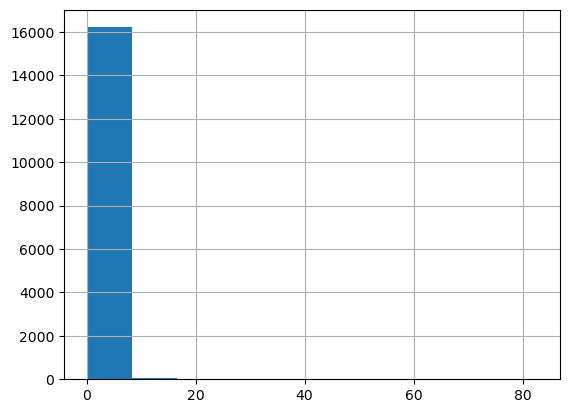

Global_Sales
82.74    1
35.82    1
33.00    1
24.76    1
21.40    1
        ..
11.66    1
5.95     1
3.14     1
4.87     1
4.23     1
Name: count, Length: 621, dtype: int64


In [27]:
# Plot a histogram for the Global Sales
df['Global_Sales'].hist(bins=10)
plt.show()

# Count the frequency of each Global Sales value
print(df['Global_Sales'].value_counts(sort=False))

In [28]:
"""
Step 2: 
Equal Width Discretization into 4 bins
This method divides the range of Global Sales into 4 bins of equal interval widths, categorizing the continuous sales data into discrete intervals.
"""

# Equal Width Discretization into 4 bins
bins_equal_width = pd.cut(df['Global_Sales'], 4)
print(bins_equal_width.value_counts(sort=False))

Global_Sales
(-0.0727, 20.692]    16273
(20.692, 41.375]        17
(41.375, 62.057]         0
(62.057, 82.74]          1
Name: count, dtype: int64


In [29]:
"""
Step 3:
Equal Frequency Discretization into 4 bins
This method divides the Global Sales data into 4 bins such that each bin contains approximately the same number of records, ensuring an even distribution across bins
"""
# Equal Frequency Discretization into 4 bins
bins_equal_freq = pd.qcut(df['Global_Sales'], 4)
print(bins_equal_freq.value_counts(sort=False))

Global_Sales
(0.009000000000000001, 0.06]    4266
(0.06, 0.17]                    3963
(0.17, 0.48]                    4039
(0.48, 82.74]                   4023
Name: count, dtype: int64


# Aggregation

Author: Isaiah Samaniego | The purpose is to aggregate NA, EU, JP, and Other sales into the single object Global_Sales

In [30]:
x = df.drop('Global_Sales', axis=1)
#Aggregates NA,EU, JP, and Other sales into the single object Global_Sales
x['Global_Sales'] = x[['NA_Sales', 'EU_Sales', 'JP_Sales', 'Other_Sales']].sum(axis=1)
print(x)

                                     Name Platform    Year         Genre  \
14610                          Wii Sports      Wii  2006.0        Sports   
10238                      Mario Kart Wii      Wii  2008.0        Racing   
12607                   Wii Sports Resort      Wii  2009.0        Sports   
1050                           Nintendogs       DS  2005.0    Simulation   
15285                  Grand Theft Auto V      PS3  2013.0        Action   
...                                   ...      ...     ...           ...   
6471   Shaman King: Chou Senjiryokketsu 3      GBA  2002.0  Role-Playing   
14754                     Motto! SoniComi      PS3  2014.0    Simulation   
8174                          Mega Man ZX       DS  2006.0      Platform   
14809     Memories Off: Yubikiri no Kioku     X360  2010.0     Adventure   
5201   S.Y.K: Shinsetsu Saiyuuki Portable      PSP  2010.0     Adventure   

                  Publisher  NA_Sales  EU_Sales  JP_Sales  Other_Sales  \
14610        